In [1]:
import torch 
import numpy as np
import math
from embedders import LDSVRNN, MixtureLDSE2C, PhysicsLDSE2C
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from IPython import display

In [2]:
class PointMass:
    
    def __init__(self,size=5,w=64,dt=0.1,umax=100):
        self.size = 5
        self.W = 64
        
        self.A = np.eye(2)
        self.B = np.array([[dt,0],
                      [0,dt]])
        self.C = 0.5*np.array([[dt*dt,0],
                      [0,dt*dt]])
        
        self.umax = umax/2
        
        self.reset()
        
    def reset(self):
        self.v = np.zeros((2,1))
        self.x = np.random.randint(self.size,self.W-self.size,(2,1))

    def true_dynamics(self,u):

        self.v = self.v + self.C@u
        self.x = np.clip(self.A@self.x + self.B@self.v,5,59) 

        return self.x
    
    def sample_u(self):
        
        return 2*self.umax*np.random.rand(2,1)-self.umax

    def render(self):

        im = np.zeros((3,self.W,self.W))
        xc = np.round(self.x[0]).astype(int)[0]
        yc = np.round(self.x[1]).astype(int)[0]
        im[:,xc-self.size:xc+self.size,yc-self.size:yc+self.size] = 1.0

        return im
    

In [3]:
#Generate some fake data
pm = PointMass()

Ntrajs = 1000
seq_len = 32

im_list = []
x_list = []
a_list = []
for k in range(Ntrajs):
    
    pm.reset()
    for j in range(seq_len): 
        
        u = pm.sample_u()
        a_list.append(u/pm.umax)
        x_list.append(pm.true_dynamics(u))

        im = pm.render()
        im_list.append(im)
    

In [4]:
class SeqDataset(Dataset):
    
    def __init__(self, im_list,x_list,a_list,seq_len=8,device ='cuda'):
        
        self.x = torch.from_numpy(np.vstack(x_list).reshape(-1,seq_len,2)).to(device).float()
        self.ims = torch.from_numpy(np.vstack(im_list).reshape(-1,seq_len,3,64,64)).to(device).float()
        self.acts = torch.from_numpy(np.vstack(a_list).reshape(-1,seq_len,2)).to(device).float()

    def __len__(self):
        return self.ims.shape[0]

    def __getitem__(self, idx):
        
        return self.ims[idx], self.acts[idx], self.x[idx]

In [7]:
img_shape = im_list[0][np.newaxis,:,:].shape
action_dim = 2
state_dim = 2
batch_size = 128
device = 'cuda'

training_data = SeqDataset(im_list,x_list,a_list,seq_len,device)
dl = DataLoader(training_data, batch_size=batch_size, shuffle=True)

net = PhysicsLDSE2C(img_shape, action_dim, state_dim).to(device)

optimizer = torch.optim.Adam(net.parameters(),lr=1e-3)
losses_recon = []
losses_trans = []

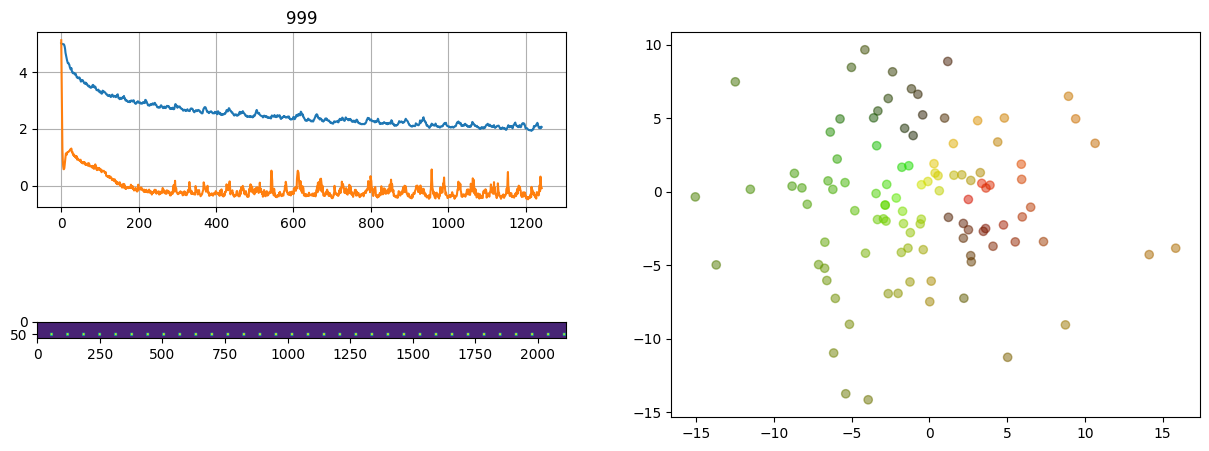

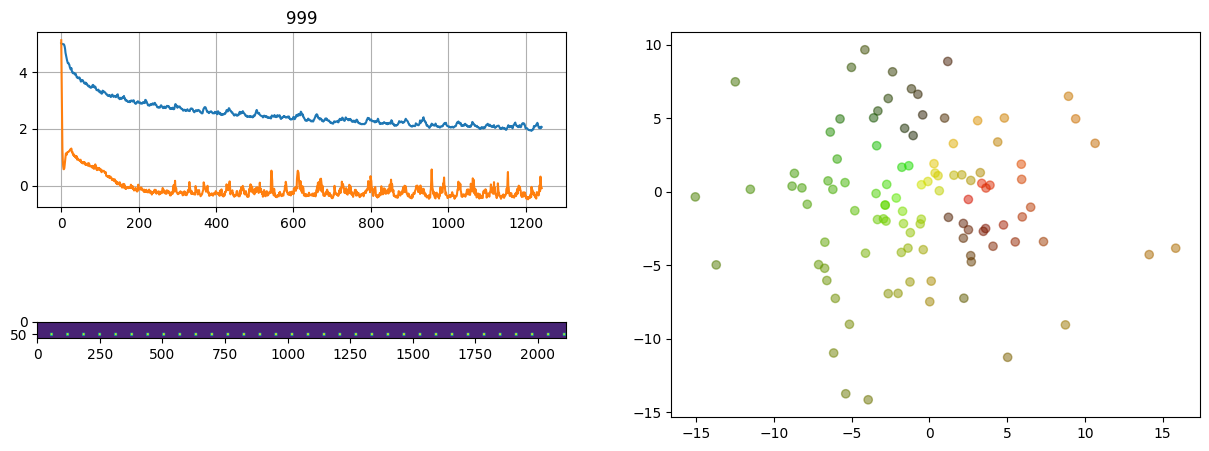

In [10]:
plt.figure(figsize=(15,5))
for epoch in range(1000):
    
    batch_losses_recon = []
    batch_losses_trans = []
    for im,act,x in dl:
        
        batch = dict()
        batch['img'] = im
        batch['act'] = act
        batch['xgt'] = x
        
        out = net(batch,train=True)    
    
        lls = net.compute_losses(batch,out,epoch=epoch)    
    
        optimizer.zero_grad()
        loss = lls['trans_pos_kl']+lls['next_rec']#+lls['consistency'] #lls['ll_loss']+lls['kl_loss']
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1000.0)
        optimizer.step()
        
        batch_losses_recon.append(lls['next_rec'].item())
        batch_losses_trans.append(lls['trans_pos_kl'].item())
    
        # if reps%10==0:

    losses_recon.append(np.mean(batch_losses_recon))
    losses_trans.append(np.mean(batch_losses_trans))
    plt.clf()
    plt.subplot(2,2,1)
    plt.plot(np.log(losses_recon))
    plt.plot(np.log(losses_trans))
    plt.grid()
    plt.title(epoch)
    plt.subplot(2,2,3)
    plt.imshow(np.hstack((batch['img'][0,:,0,:,:].reshape(-1,64).cpu().T,out['recons'][0,0,:,:].reshape(-1,64).detach().cpu().T)))

    support = out['next_pos_posterior'].mean.detach().cpu().numpy()
    cols = (batch['xgt']).detach().cpu().numpy()
    cl = np.hstack((cols[:,-1,:],np.zeros((cols.shape[0],1))))/64

    plt.subplot(1,2,2)
    plt.scatter(support[:,0],support[:,1],c=cl,alpha=0.5)

    display.clear_output(wait=True)
    display.display(plt.gcf())
    

KeyboardInterrupt: 

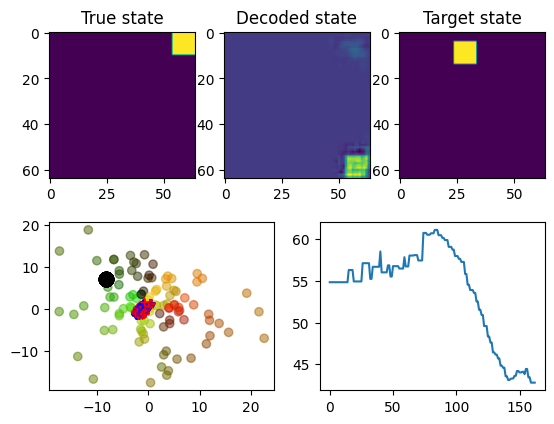

In [9]:
target_frame = im_list[np.random.randint(len(im_list))]
target_state = net.posterior(torch.from_numpy(target_frame)[None,:].to("cuda").float()).mean

Kp = 1
Kd = 0

pm.reset()
init_frame = pm.render()

seq_len = 8
batch['img'] = torch.stack([torch.from_numpy(init_frame) for i in range(seq_len)])[np.newaxis,:].float().to('cuda')
batch['act'] = torch.stack([torch.zeros(action_dim) for i in range(seq_len)])[np.newaxis,:,:].float().to('cuda')

plt.subplot(2,2,3)
plt.scatter(support[:,0],support[:,1],c=cl,alpha=0.5)

pre_state = net.posterior(torch.from_numpy(init_frame)[None,:].to("cuda").float()).mean

norm_error = []
for j in range(200):
    
    im = pm.render()
    
    state = net.posterior(torch.from_numpy(im)[None,:].to("cuda").float()).mean
    cov = net.posterior(torch.from_numpy(im)[None,:].to("cuda").float()).variance
    
    u = -Kp*(state-target_state).reshape(-1,1) - Kd*(state-pre_state)/0.1
    
    norm_error.append(np.mean((state-target_state).detach().cpu().numpy()**2))
    
    pre_state = state
    
    x = pm.true_dynamics(u.detach().cpu().numpy())
    
    st = net.posterior(net.decode(state)).mean
    
    plt.subplot(2,3,1)
    plt.cla()
    plt.imshow(im[0,:,:])
    plt.title('True state')
    plt.subplot(2,3,2)
    plt.cla()
    plt.imshow(net.decode(state)[0,0,:,:].detach().cpu())
    plt.title('Decoded state')
    plt.subplot(2,3,3)
    plt.cla()
    plt.imshow(target_frame[0,:,:])
    plt.title('Target state')
    plt.subplot(2,2,3)
    u = state.detach().cpu().numpy().ravel()[0]
    v = state.detach().cpu().numpy().ravel()[1]
    # a = np.sqrt(cov.detach().cpu().numpy().ravel()[0])*3
    # b = np.sqrt(cov.detach().cpu().numpy().ravel()[1])*3
    plt.plot(u,v,'b+')
    # t = np.linspace(0, 2*np.pi, 100)
    # plt.plot(u + a*np.cos(t) , v + b*np.sin(t),'g')
    plt.plot(st.detach().cpu().numpy().ravel()[0],st.detach().cpu().numpy().ravel()[1],'r+')
    plt.plot(target_state.detach().cpu().numpy().ravel()[0],target_state.detach().cpu().numpy().ravel()[1],'ko',markersize=10)
    
    plt.subplot(2,2,4)
    plt.cla()
    plt.plot(norm_error)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    